

# 두 자산간 가격 차이를 이용한 헷징 매매 전략 지도학습
두 자산간 가격 차이를 나타낸 시계열 데이터에서 이상적인 동작 (buy=0, sell=1) 을 학습하고, 이를 예측하는 지도학습 모델.

<a id='1.1'></a>
## 1.1. 패키지 로드

In [2]:
# 라이브러리 로드
import heapq
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense

<a id='1.2'></a>
## 1.2. 데이터 가져오기

In [74]:
working_dir = 'data/'

# price_funding.csv에서 dataset 저장
rawdataset = pd.read_csv(working_dir+'price_funding.csv')

#경고 무시
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 2. 탐색적 데이터 분석

<a id='2.1'></a>
## 2.1. 기술 통계

In [47]:
# 데이터셋 구조 확인
rawdataset.shape

# 데이터 확인
pd.set_option('display.width', 100)
rawdataset.tail(5)

,timestamp,spot_close,futures_close,price_diff,Funding Rate
1483,2025-02-02 19:00:00,98260.09,98223.3,36.79,0.000000
1484,2025-02-02 18:00:00,97083.70,97048.2,35.50,0.000000
1485,2025-02-02 17:00:00,97245.13,97201.6,43.53,0.000000
1486,2025-02-02 16:00:00,98257.92,98220.9,37.02,0.000088
1487,2025-02-02 15:00:00,99340.80,99292.7,48.10,0.000000


<a id='3'></a>
# 3. 데이터 준비

<a id='3.1'></a>
## 3.1. 데이터 청소

In [5]:
# null 값 확인
print('Null Values =',rawdataset.isnull().values.any())

Null Values = False


nan값 있으면 dropna로 삭제하든 ffill로 보간하든 해야한다. 안하면 나중에 오류남

In [6]:
# null 값 보간
rawdataset[rawdataset.columns.values] = rawdataset[rawdataset.columns.values].ffill()

In [43]:
rawdataset.tail()

,price_diff
5,5
6,3
7,6
8,7
9,6


<a id='3.3'></a>
## 3.2. 특성 엔지니어링




예측을 만들기 위한 특성들을 정의한다.

아직 이건 연구가 더 필요하다. 모델 성능에 가장 중요한 영향을 주는데, 가장 부족한 부분이다.

In [148]:
# 가격 데이터 정의
df = rawdataset["price_diff"]

# 매수 시점별로 가장 높은 수익을 기록할 딕셔너리
best_profits = {}

# 상위 n 개를 입력받음
n = int(input("상위 몇 개의 수익 데이터를 선택하시겠습니까? (예: 5): "))

# tqdm을 사용하여 진행 상황을 시각화하면서 l을 1부터 len(df)-1까지 순회
for l in tqdm(range(1, 20), desc="Calculating profits", unit="period"):
    for i in range(len(df) - l):  # i는 매수 시점의 인덱스
        buy_price = df[i]  # 매수 시점의 가격
        sell_price = df[i + l]  # 매도 시점의 가격
        profit = sell_price - buy_price  # 수익 계산

        # 매수 시점 i에서 가장 높은 수익만 기록
        if i not in best_profits or profit > best_profits[i]:
            best_profits[i] = profit

# 딕셔너리에서 수익을 내림차순으로 정렬
sorted_profits = sorted(best_profits.items(), key=lambda x: x[1], reverse=True)

# 상위 n개의 데이터 추출
top_n_profits = sorted_profits[:n]

# trade_actions 리스트 초기화
trade_actions = [0] * len(df)

# 상위 n개의 매수 시점에 대해 거래 액션을 1로 설정
for i, _ in top_n_profits:
    trade_actions[i] = 1

# # 거래 액션이 1인 지점의 트렌드 출력
# print(f"상위 {n}개의 수익 데이터:")
# for i, profit in top_n_profits:
#     print(f"매수 시점: {i}, 수익: {profit}")

# # 거래 액션 리스트 출력
# print("\n거래 액션 리스트:")
# print(trade_actions)

상위 몇 개의 수익 데이터를 선택하시겠습니까? (예: 5): 500


Calculating profits: 100%|██████████| 19/19 [00:00<00:00, 85.78period/s]


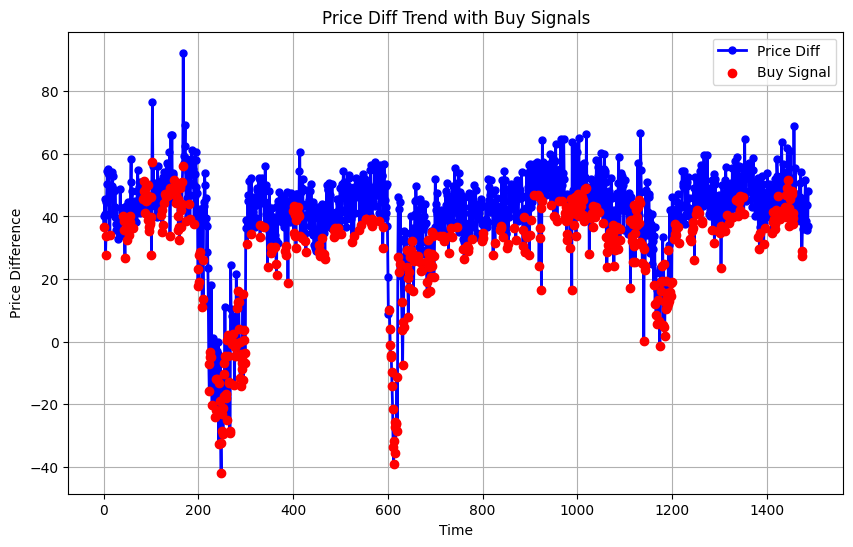

In [154]:
# 트렌드를 시각화 (가격 차이 그래프)
plt.figure(figsize=(10, 6))
plt.plot(df, label='Price Diff', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2)

# 거래 액션이 1인 지점 표시 (매수 시점)
buy_indices = [i for i in range(len(trade_actions)) if trade_actions[i] == 1]
buy_prices = [df[i] for i in buy_indices]
plt.scatter(buy_indices, buy_prices, color='red', label='Buy Signal', zorder=5)

# 그래프에 레이블 추가
plt.title('Price Diff Trend with Buy Signals')
plt.xlabel('Time')
plt.ylabel('Price Difference')
plt.legend(loc='best')

# 그래프 표시
plt.grid(True)
plt.show()


In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 가격 데이터 정의
df = rawdataset["price_diff"]

# 매수 기간별로 가장 높은 수익을 기록할 딕셔너리
best_profits = {}

# 상위 n 개를 입력받음
n = int(input("상위 몇 개의 수익 데이터를 선택하시겠습니까? (예: 5): "))

# tqdm을 사용하여 진행 상황을 시각화하면서 l을 1부터 30까지 순회
for l in tqdm(range(1, 30), desc="Calculating profits", unit="period"):
    for i in range(len(df) - l):  # i는 매수 시작 시점의 인덱스
        buy_price = df[i]  # 매수 시작 시점의 가격
        sell_price = df[i + l]  # 매도 시점의 가격
        profit = sell_price - buy_price  # 수익 계산

        # 매수 시작 시점 i에서 가장 높은 수익만 기록
        if i not in best_profits or profit > best_profits[i]:
            best_profits[i] = profit

# 딕셔너리에서 수익을 내림차순으로 정렬
sorted_profits = sorted(best_profits.items(), key=lambda x: x[1], reverse=True)

# 상위 n개의 데이터 추출
top_n_profits = sorted_profits[:n]

# 단일 리스트 trade_actions 초기화
trade_actions = [0] * len(df)

# 상위 n개의 매수 기간에 대한 거래 액션 기록
for i, _ in top_n_profits:
    for j in range(i, i + l):  # 매도 시점까지
        if j < len(trade_actions):  # 리스트 범위를 넘지 않도록 조건 추가
            trade_actions[j] = 1

# 거래 액션 리스트 출력
print("\n거래 액션 리스트:")
print(trade_actions)

# 트렌드를 시각화 (가격 차이 그래프)
plt.figure(figsize=(10, 6))
plt.plot(df, label='Price Diff', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2)

# 거래 액션이 1인 지점 표시 (매수 기간)
buy_indices = [i for i in range(len(trade_actions)) if trade_actions[i] == 1]
buy_prices = [df[i] for i in buy_indices]
plt.scatter(buy_indices, buy_prices, color='red', label='Buy Signal', zorder=5)

# 그래프에 레이블 추가
plt.title('Price Diff Trend with Buy Signals')
plt.xlabel('Time')
plt.ylabel('Price Difference')
plt.legend(loc='best')

# 그래프 표시
plt.grid(True)
plt.show()


KeyboardInterrupt: Interrupted by user

In [156]:
# 기존 df에 병합 및 dataset 최신화
dataset = pd.DataFrame({'Price': df, 'action': trade_actions})

In [157]:
# EMA 계산
def EMA(df, n):
    EMA = pd.Series(df['Price'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA1'] = EMA(dataset, 1)
dataset['EMA3'] = EMA(dataset, 3)
dataset['EMA10'] = EMA(dataset, 10)
dataset.head()

# 모멘텀 (MOM) 계산
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM1'] = MOM(dataset['Price'], 1)
dataset['MOM3'] = MOM(dataset['Price'], 3)

#상대강도지수 (RSI) 계산
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI1'] = RSI(dataset['Price'], 1)
dataset['RSI3'] = RSI(dataset['Price'], 3)
dataset['RSI10'] = RSI(dataset['Price'], 10)

# 이동평균 (MA) 계산
def MA(df, n):
    MA = pd.Series(df['Price'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA1'] = MA(dataset, 1)
dataset['MA3'] = MA(dataset, 3)
dataset['MA10'] = MA(dataset, 10)

In [158]:
dataset.tail()

,Price,action,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,RSI10,MA1,MA3,MA10
1483,36.79,0,36.79,39.922838,41.819092,-1.58,-7.49,0.0,29.691870,44.600167,36.79,42.216667,40.845
1484,35.50,0,35.50,37.711419,40.670166,-1.29,-15.99,0.0,26.518625,43.555147,35.50,36.886667,41.500
1485,43.53,0,43.53,40.620710,41.190136,8.03,5.16,100.0,63.220527,51.426835,43.53,38.606667,42.042
1486,37.02,0,37.02,38.820355,40.431929,-6.51,0.23,0.0,39.331156,45.687473,37.02,38.683333,42.144
1487,48.10,0,48.10,43.460177,41.826124,11.08,12.60,100.0,69.120708,55.152616,48.10,42.883333,42.410


In [159]:
dataset = dataset.dropna(axis=0)

In [160]:
dataset.tail()

,Price,action,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,RSI10,MA1,MA3,MA10
1483,36.79,0,36.79,39.922838,41.819092,-1.58,-7.49,0.0,29.691870,44.600167,36.79,42.216667,40.845
1484,35.50,0,35.50,37.711419,40.670166,-1.29,-15.99,0.0,26.518625,43.555147,35.50,36.886667,41.500
1485,43.53,0,43.53,40.620710,41.190136,8.03,5.16,100.0,63.220527,51.426835,43.53,38.606667,42.042
1486,37.02,0,37.02,38.820355,40.431929,-6.51,0.23,0.0,39.331156,45.687473,37.02,38.683333,42.144
1487,48.10,0,48.10,43.460177,41.826124,11.08,12.60,100.0,69.120708,55.152616,48.10,42.883333,42.410


<a id='3.4'></a>
## 3.3. 데이터 시각화

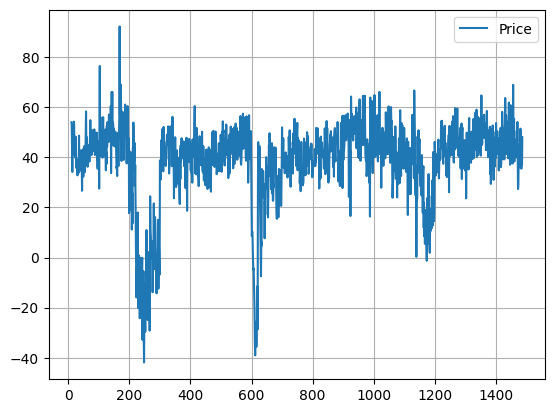

In [161]:
# 트렌드
dataset[['Price']].plot(grid=True)
plt.show()

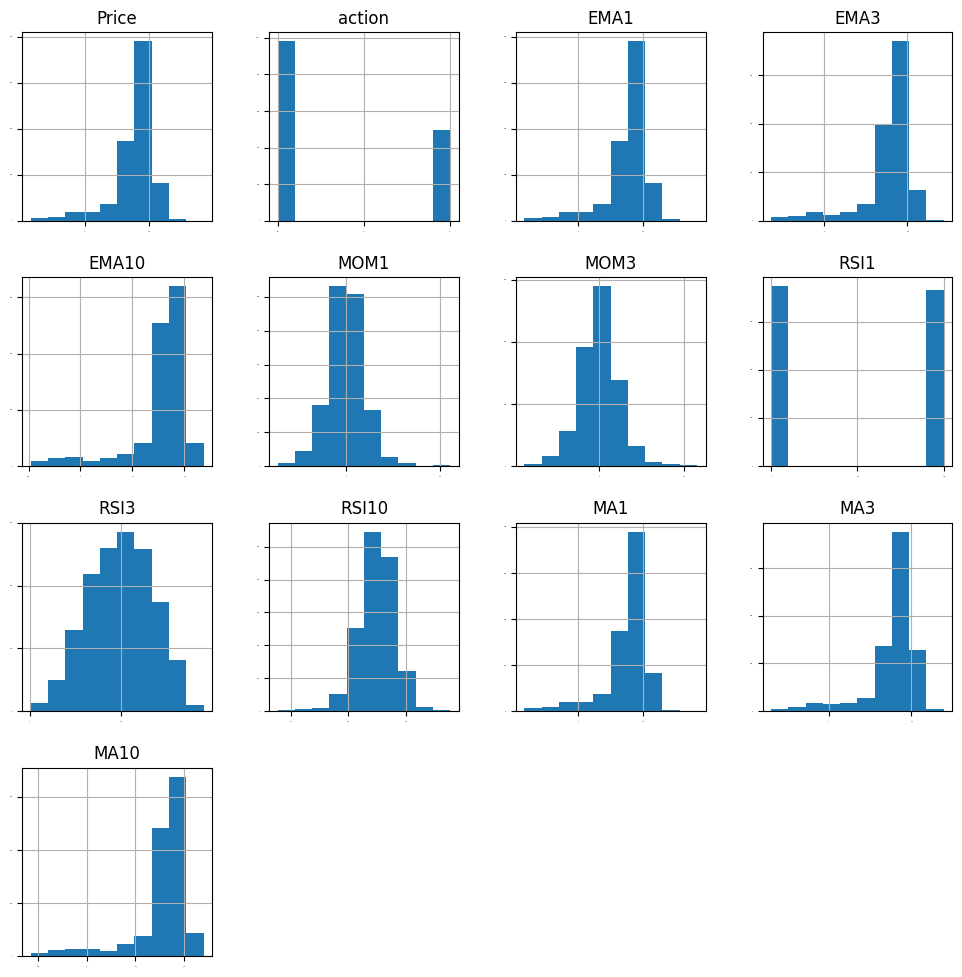

In [162]:
# 히스토그램
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

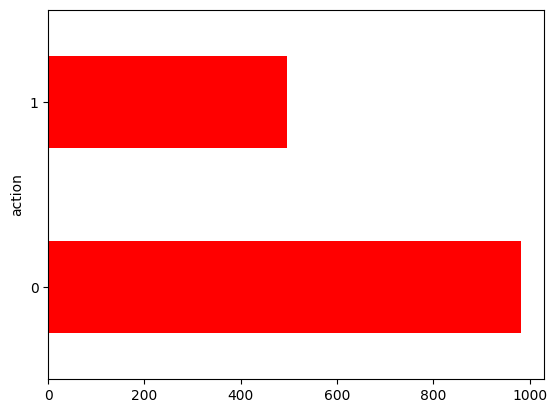

In [163]:
# 행동들 간 비율
fig = plt.figure()
plot = dataset.groupby(['action']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

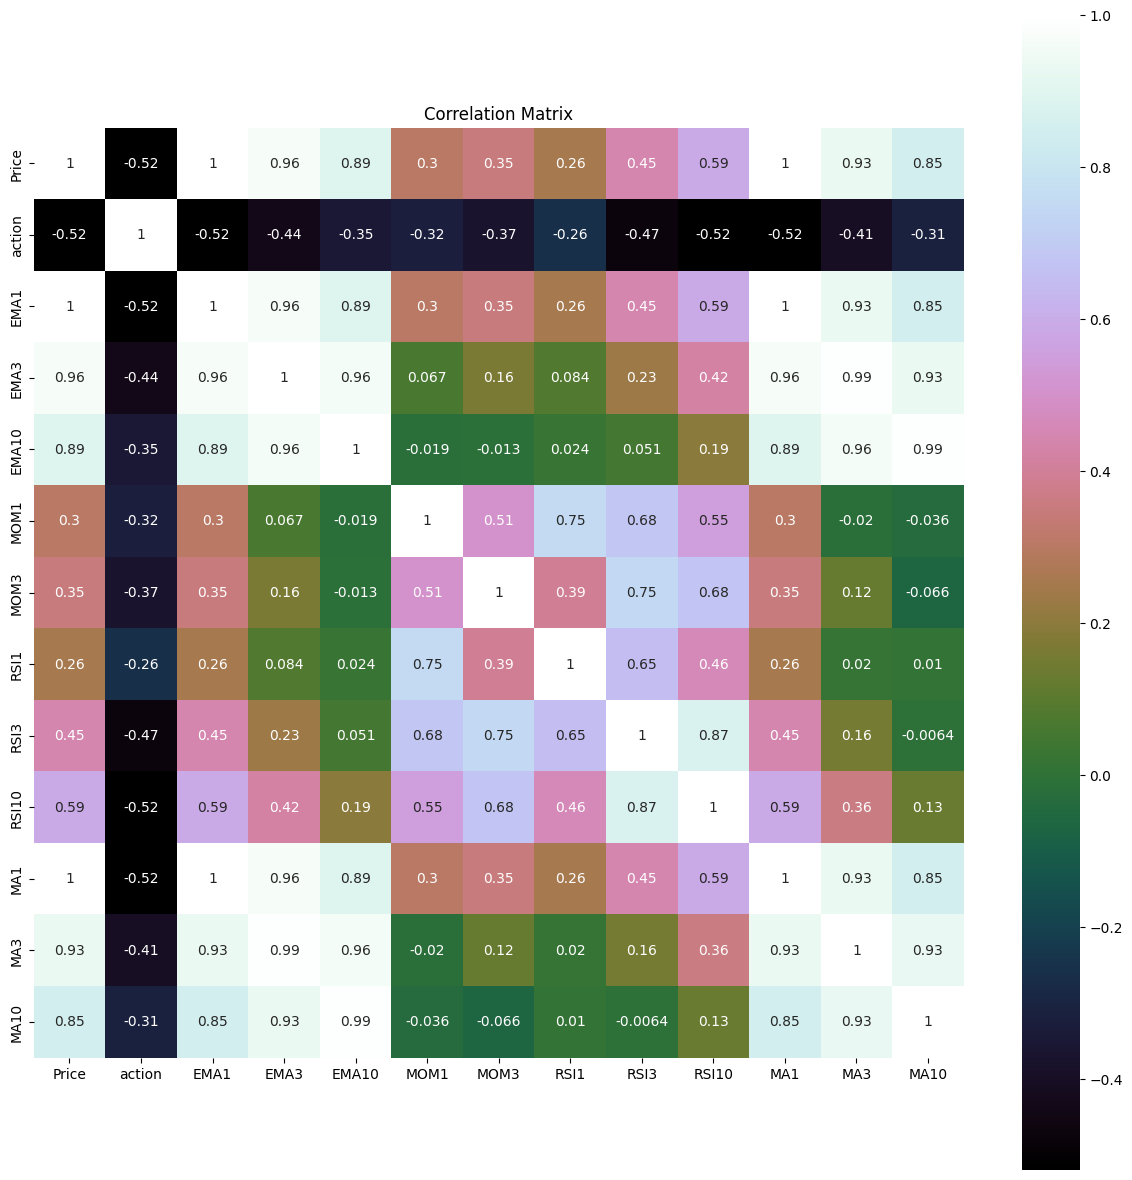

In [164]:
# 상관계수
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 4. 알고리즘 및 모델 평가

<a id='4.1'></a>
## 4.1. train test 분리

80퍼는 학습셋으로, 20퍼는 평가셋으로

In [204]:
subset_dataset= dataset
Y= subset_dataset["action"]
X = subset_dataset.loc[:, dataset.columns != 'action']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 4.2. 테스트 옵션 및 평가 지표


In [203]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 4.3. 모델 및 알고리즘 비교

<a id='4.3.1'></a>
### 4.3.1. 모델 정의

In [199]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# 신경망 생성 함수
def create_nn():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # 배치 정규화 추가
    model.add(Dropout(0.1))  # 드롭아웃 추가

    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 사용

    # Adam 옵티마이저 사용
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 모델 생성
keras_model = create_nn()

# 조기 종료 적용
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
keras_model.fit(
    X_train, Y_train,
    epochs=500,  # 충분한 에포크 설정
    batch_size=32,
    validation_data=(X_validation, Y_validation),  # 검증 데이터 추가
    callbacks=[early_stopping],  # 조기 종료 적용
    verbose=1
)

# 예측
y_pred_keras = keras_model.predict(X_validation)
y_pred_keras = (y_pred_keras > 0.5).astype(int)  # 이진 분류 문제로 변환

# 정확도 출력
accuracy_keras = accuracy_score(Y_validation, y_pred_keras)
print(f"Keras 모델 정확도: {accuracy_keras}")


Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.7104 - loss: 12.5400 - val_accuracy: 0.6858 - val_loss: 10.6338
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7148 - loss: 9.5974 - val_accuracy: 0.7095 - val_loss: 7.9499
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7971 - loss: 7.1934 - val_accuracy: 0.6892 - val_loss: 5.8462
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7772 - loss: 5.3593 - val_accuracy: 0.7770 - val_loss: 4.2681
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7972 - loss: 3.9878 - val_accuracy: 0.7939 - val_loss: 3.2351
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7883 - loss: 3.0853 - val_accuracy: 0.7635 - val_loss: 2.5204
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7923 - loss: 2.3143 - val_accuracy: 0.8142 - val_loss: 1.9481
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7828 - loss: 1.8316 - val_accuracy: 0.804

### 4.3.2. K-겹 교차 검증

In [200]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.807072 (0.025285)
LDA: 0.791839 (0.034327)
KNN: 0.790194 (0.019850)
CART: 0.736896 (0.031243)
NB: 0.790984 (0.034158)
NN: 0.793548 (0.038604)
AB: 0.799473 (0.017908)
GBM: 0.799445 (0.021149)
RF: 0.797771 (0.029139)


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (10).

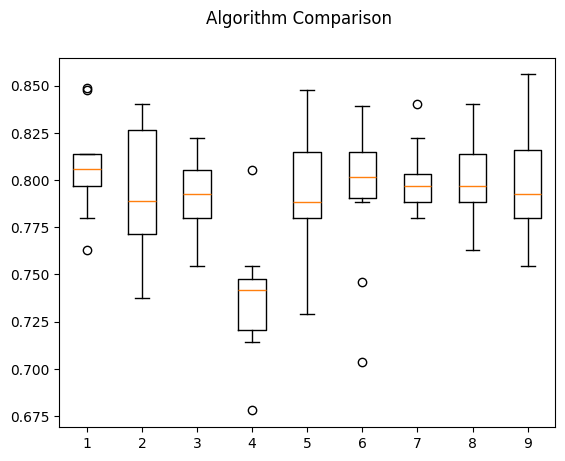

In [205]:
# 알고리즘 비교
# results.append([accuracy_keras] * len(results[0]))  # accuracy_keras 값을 모든 항목에 추가 (같은 값 반복)
# names.append('Keras')
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 5. 그리드 서치를 통한 모델 튜닝

랜덤 포레스트의 하이퍼파라미터를 그리드 서치 선택하여 튜닝한다.

In [206]:
# 랜덤 포레스트 그리드 서치
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# 결과 출력
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.815518 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#3 0.809586 (0.047685) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#2 0.810433 (0.036886) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#6 0.801966 (0.048617) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#5 0.803653 (0.044324) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#4 0.806231 (0.039400) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#1 0.815518 (0.041367) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#8 0.798590 (0.035204) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#7 0.801118 (0.044052) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


<a id='6'></a>
# 6. 최적 모델 정의

<a id='6.1'></a>
## 6.1. 테스트셋에서의 성능 평가

In [210]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1)
model.fit(X_train, Y_train)
# model = LogisticRegression()
# model = create_nn()
# model.fit(X_train, Y_train, epochs=500, batch_size=32, verbose=1)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [211]:
predictions = model.predict(X_validation)
# predictions = (model.predict(X_validation) > 0.5).astype(int)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8175675675675675
[[180  17]
 [ 37  62]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       197
           1       0.78      0.63      0.70        99

    accuracy                           0.82       296
   macro avg       0.81      0.77      0.78       296
weighted avg       0.81      0.82      0.81       296



<Axes: xlabel='Predicted', ylabel='Actual'>

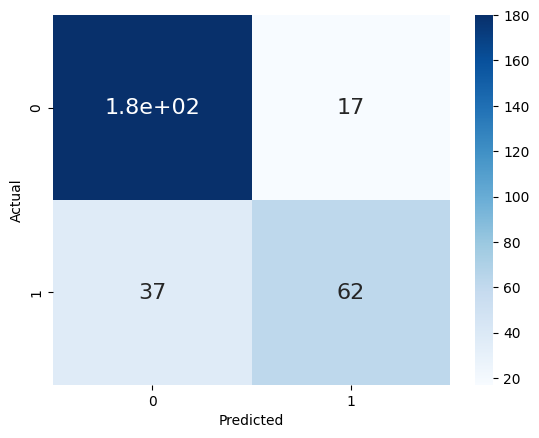

In [212]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

<a id='6.2'></a>
## 6.2. 변수 및 특성 중요도
모델에서 가장 중요한 특성 및 변수를 알아보자

Text(0.5, 0, 'Variable Importance')

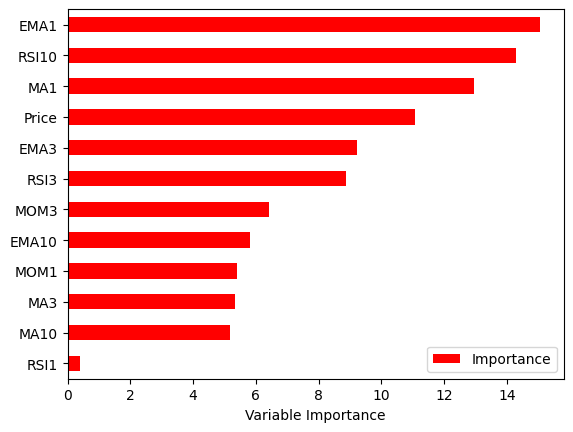

In [213]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 7. 결과 백테스트

<Axes: >

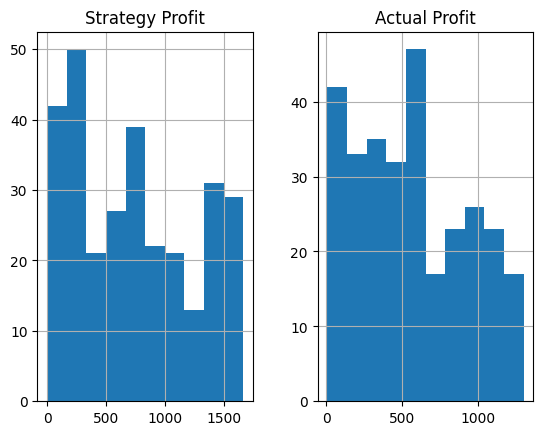

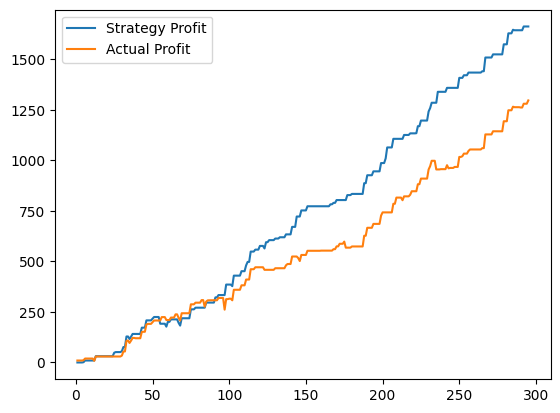

In [214]:
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['action_pred'] = predictions
backtestdata['action_actual'] = Y_validation
# backtestdata['Market Returns'] = X_validation['Price'].pct_change()
# backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['action_actual'].shift(1)
# backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['action_pred'].shift(1)
backtestdata['Market Profit'] = X_validation['Price'].diff()
backtestdata['Strategy Profit'] = backtestdata['Market Profit'] * (backtestdata['action_pred'].shift(1) == 1)
backtestdata['Actual Profit'] = backtestdata['Market Profit'] * (backtestdata['action_actual'].shift(1) == 1)

backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().hist()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().plot()